In [1]:
import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
from sklearn.model_selection import train_test_split
from IPython.display import display, SVG, clear_output
import os

In [ ]:
visualize = False
mode = 'play'
player_color = 'black'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
if visualize:
    pgn_path = "lichess_elite_2022-02.pgn"
    max_games = 20000
    data = {
        "white_elo": [],
        "black_elo": [],
        "elo_diff": [],
        "result": [],
        "termination": [],
        "game_length": [],
        "eco": [],
        "opening": [],
        "time_control": []
    }
    plt.rcParams.update({'font.size': 12})

In [4]:
if visualize:
    game_count = 0
    with open(pgn_path, encoding="utf-8") as pgn:
        while game_count < max_games:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            try:
                white_elo = int(game.headers.get("WhiteElo", 0))
                black_elo = int(game.headers.get("BlackElo", 0))
                result = game.headers["Result"]
                termination = game.headers.get("Termination", "Unknown")
                eco = game.headers.get("ECO", "UNK")
                opening = game.headers.get("Opening", "Unknown")
                time_control = game.headers.get("TimeControl", "Unknown")
                plies = len(list(game.mainline_moves()))

                data["white_elo"].append(white_elo)
                data["black_elo"].append(black_elo)
                data["elo_diff"].append(white_elo - black_elo)
                data["result"].append(result)
                data["termination"].append(termination)
                data["eco"].append(eco)
                data["opening"].append(opening)
                data["time_control"].append(time_control)
                data["game_length"].append(plies)

                game_count += 1
            except Exception:
                continue

In [5]:
if visualize:
    df = pd.DataFrame(data)
    df["winner"] = df["result"].map({
        "1-0": "White",
        "0-1": "Black",
        "1/2-1/2": "Draw"
    })
    df["elo_diff_bucket"] = pd.cut(df["elo_diff"], bins=range(-600, 701, 100))

In [6]:
if visualize:
    plt.figure(figsize=(10, 5))
    plt.hist(df["white_elo"], bins=30, alpha=0.7, label="Białe", color="blue")
    plt.hist(df["black_elo"], bins=30, alpha=0.7, label="Czarne", color="green")
    plt.xlabel("Ranking ELO")
    plt.ylabel("Liczba partii")
    plt.title("Rozkład rankingów ELO (Białe vs Czarne)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("elo_dist.png", dpi=150)
    plt.show()

In [7]:
if visualize:
    result_labels = {"1-0": "Wygrana Białych", "0-1": "Wygrana Czarnych", "1/2-1/2": "Remis"}
    result_counts = df["result"].map(result_labels).value_counts()
    colors = ["#4B9CD3", "#999999", "#D3455B"]

    plt.figure(figsize=(6, 6))
    plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title("Rozkład wyników partii")
    plt.tight_layout()
    plt.savefig("outcomes_dist.png", dpi=150)
    plt.show()

In [8]:
if visualize:
    plt.figure(figsize=(10, 8))
    termination_counts = df["termination"].value_counts()
    ax = termination_counts.plot(kind="bar", color="red")

    plt.title("Metoda zakończenia partii")
    plt.ylabel("Liczba partii")
    plt.xlabel("Sposób zakończenia")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    for i, value in enumerate(termination_counts):
        plt.text(i, value + max(termination_counts) * 0.01, str(value), 
                ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig("methodology_dist.png", dpi=150)
    plt.show()

In [9]:
if visualize:
    plt.figure(figsize=(10, 5))
    plt.hist(df["game_length"], bins=40, color="orange", edgecolor='black')
    plt.title("Długość partii (liczba półruchów)")
    plt.xlabel("Liczba półruchów")
    plt.ylabel("Liczba partii")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("length_dist.png", dpi=150)
    plt.show()

In [10]:
if visualize:
    top_openings = df["opening"].value_counts().head(10)

    plt.figure(figsize=(10, 6))
    top_openings.plot(kind="barh", color="green")
    plt.title("10 najczęściej granych debiutów")
    plt.xlabel("Liczba partii")
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("openings_dist.png", dpi=150)
    plt.show()

In [11]:
piece_map = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}

In [12]:
def board_to_tensor(board):
    state = torch.zeros(6, 8, 8)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)
            idx = piece_map[piece.piece_type]
            state[idx, row, col] = 1 if piece.color == chess.WHITE else -1

    return state

In [13]:
def create_output_labels(from_square, to_square, piece_type):
    move_selector_target = torch.zeros((8, 8), dtype=torch.float32)
    move_selector_target[from_square[0], from_square[1]] = 1.0

    piece_selector_targets = [torch.zeros((8, 8), dtype=torch.float32) for i in range(6)]
    piece_index = piece_map[piece_type]
    piece_selector_targets[piece_index][to_square[0], to_square[1]] = 1.0

    return move_selector_target, piece_selector_targets

In [14]:
def flip_board_and_labels(board_tensor, from_row, from_col, to_row, to_col):
    flipped_tensor = torch.flip(board_tensor, dims=[1, 2])
    new_from_row = 7 - from_row
    new_from_col = 7 - from_col
    new_to_row = 7 - to_row
    new_to_col = 7 - to_col
    return flipped_tensor, new_from_row, new_from_col, new_to_row, new_to_col

In [15]:
def load_data(file, max_games):
    X_data = []
    y_move_selector = []
    y_piece_selectors = [[] for i in range(6)]

    with open(file) as pgn_file:
        game_count = 0
        while game_count < max_games:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                continue

            board = game.board()
            for move in game.mainline_moves():
                from_sq = move.from_square
                to_sq = move.to_square
                piece = board.piece_at(from_sq)
                if piece is None:
                    continue

                state_tensor = board_to_tensor(board)
                from_row, from_col = divmod(from_sq, 8)
                to_row, to_col = divmod(to_sq, 8)

                if piece.color == chess.BLACK:
                    state_tensor, from_row, from_col, to_row, to_col = flip_board_and_labels(
                        state_tensor, from_row, from_col, to_row, to_col
                    )

                move_label, piece_labels = create_output_labels(
                    from_square=(from_row, from_col),
                    to_square=(to_row, to_col),
                    piece_type=piece.piece_type
                )

                X_data.append(state_tensor)
                y_move_selector.append(move_label)

                piece_index = piece_map[piece.piece_type]
                for i in range(6):
                    if i == piece_index:
                        y_piece_selectors[i].append(piece_labels[i])
                    else:
                        y_piece_selectors[i].append(None)

                board.push(move)

            game_count += 1
            if game_count % 50000 == 0:
                print(f"Przetworzono {game_count} partii...")

    return X_data, y_move_selector, y_piece_selectors

In [16]:
def split_dataset(X, y_move, y_piece, test_size=0.2, random_seed=42):
    X_train, X_test, y_move_train, y_move_test = train_test_split(
        X, y_move, test_size=test_size, random_state=random_seed
    )

    y_piece_train = [[] for _ in range(6)]
    y_piece_test = [[] for _ in range(6)]
    X_piece_train = [[] for _ in range(6)]
    X_piece_test = [[] for _ in range(6)]

    for i in range(6):
        filtered = [(x, y) for x, y in zip(X, y_piece[i]) if y is not None]
        if not filtered:
            continue
        X_i, y_i = zip(*filtered)

        X_tr, X_te, y_tr, y_te = train_test_split(
            list(X_i), list(y_i), test_size=test_size, random_state=random_seed
        )
        X_piece_train[i] = X_tr
        X_piece_test[i] = X_te
        y_piece_train[i] = y_tr
        y_piece_test[i] = y_te

    return X_train, X_test, y_move_train, y_move_test, X_piece_train, X_piece_test, y_piece_train, y_piece_test

In [17]:
if mode == 'train':
    X_data, y_move_data, y_piece_data = load_data(file='lichess_elite_2022-02.pgn', max_games=20000)
    X_train, X_test, y_train, y_test, X_piece_train, X_piece_test, y_piece_train, y_piece_test = split_dataset(
        X_data, y_move_data, y_piece_data
    )

In [18]:
class ConvChessNet(nn.Module):
    def __init__(self):
        super(ConvChessNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=96, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(384 * 8 * 8, 64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        
        return x.view(-1, 8, 8)

In [19]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean=0.0, std=1e-7)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=1e-6)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [20]:
piece_selector_model = ConvChessNet().to(device)
move_selector_models = [ConvChessNet().to(device) for i in range(6)]
loss_fn = nn.CrossEntropyLoss()

piece_selector_optimizer = optim.RMSprop(piece_selector_model.parameters(), lr=0.0015, weight_decay=0.0001, alpha=0.999)
move_selector_optimizers = [
    optim.RMSprop(model.parameters(), lr=0.0015, weight_decay=0.0001, alpha=0.999)
    for model in move_selector_models
]

In [21]:
def train_and_evaluate(model, optimizer, X_train, y_train, X_test, y_test, epochs, name="", batch_size=250, num_classes=64):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    def convert_to_class_indices(y):
        return torch.tensor([t.view(-1).argmax().item() for t in y], dtype=torch.long)

    y_train_indices = convert_to_class_indices(y_train)
    y_test_indices = convert_to_class_indices(y_test)

    for epoch in range(epochs):
        X_shuffled = X_train[:]
        y_shuffled = y_train_indices.tolist()
        combined = list(zip(X_shuffled, y_shuffled))
        random.shuffle(combined)
        X_shuffled, y_shuffled = zip(*combined)
        X_shuffled = list(X_shuffled)
        y_shuffled = torch.tensor(y_shuffled, dtype=torch.long)

        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for i in range(0, len(X_shuffled), batch_size):
            X_batch = torch.stack(X_shuffled[i:i+batch_size]).float().to(device)
            y_batch = y_shuffled[i:i+batch_size].to(device)

            optimizer.zero_grad()
            outputs = model(X_batch).view(-1, num_classes)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        num_batches = math.ceil(len(X_shuffled) / batch_size)
        avg_train_loss = total_loss / num_batches
        train_accuracy = correct / total

        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for x, y in zip(X_test, y_test_indices):
                x = x.unsqueeze(0).float().to(device)
                y = torch.tensor([y]).to(device)
                output = model(x).view(1, num_classes)
                loss = loss_fn(output, y)
                val_loss += loss.item()
                pred = output.argmax(dim=1)
                val_correct += (pred == y).sum().item()
                val_total += 1

        avg_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        train_accs.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accs.append(val_accuracy)

        print(f"[{name}] Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
              f"Train Acc: {train_accuracy:.2%} | Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2%}")

    torch.save(model.state_dict(), f"{name}_model_black.pt")

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, epochs+1), train_losses, color="tab:blue", label="Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.set_title(f"Training metrics ({name})")
    ax1.grid(True, linewidth=0.4, alpha=0.6)

    ax2 = ax1.twinx()
    ax2.plot(range(1, epochs+1), train_accs, color="tab:orange", label="Train Accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis='y', labelcolor="tab:orange")
    ax2.set_ylim(0, 1)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    fig.tight_layout()
    plt.savefig(f"{name}_training_metrics.png", dpi=150)
    plt.show()

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, epochs+1), val_losses, color="tab:blue", label="Val Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.set_title(f"Validation metrics ({name})")
    ax1.grid(True, linewidth=0.4, alpha=0.6)

    ax2 = ax1.twinx()
    ax2.plot(range(1, epochs+1), val_accs, color="tab:orange", label="Val Accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis='y', labelcolor="tab:orange")
    ax2.set_ylim(0, 1)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    fig.tight_layout()
    plt.savefig(f"{name}_validation_metrics.png", dpi=150)
    plt.show()

In [22]:
piece_selector_model = ConvChessNet().to(device)
initialize_weights(piece_selector_model)

if os.path.exists("PieceSelector_model_white.pt"):
    piece_selector_model.load_state_dict(torch.load("PieceSelector_model_white.pt", map_location=device))
    piece_selector_model.eval()
    print("Loaded Piece Selector model.")
else:
    piece_selector_optimizer = optim.RMSprop(piece_selector_model.parameters(), lr=0.0015, weight_decay=0.0001, alpha=0.999)
    print("Training Piece Selector CNN:")
    train_and_evaluate(
        model=piece_selector_model,
        optimizer=piece_selector_optimizer,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        name="PieceSelector",
        epochs=15
    )

move_selector_models = []
for i in range(6):
    model = ConvChessNet().to(device)
    model_name = f"MoveSelector-{i}_model_white.pt"

    if os.path.exists(model_name):
        model.load_state_dict(torch.load(model_name, map_location=device))
        model.eval()
        print(f"Loaded Move Selector model for piece index {i}.")
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=0.0015, weight_decay=0.0001, alpha=0.999)
        print(f"\nTraining Move Selector CNN for piece index {i}")
        train_and_evaluate(
            model=model,
            optimizer=optimizer,
            X_train=X_piece_train[i],
            y_train=y_piece_train[i],
            X_test=X_piece_test[i],
            y_test=y_piece_test[i],
            name=f"MoveSelector-{i}",
            epochs=15
        )

    move_selector_models.append(model)

Loaded Piece Selector model.
Loaded Move Selector model for piece index 0.
Loaded Move Selector model for piece index 1.
Loaded Move Selector model for piece index 2.
Loaded Move Selector model for piece index 3.
Loaded Move Selector model for piece index 4.
Loaded Move Selector model for piece index 5.


In [23]:
def predict_move(board, piece_selector_model, move_selector_models):
    state_tensor = board_to_tensor(board).unsqueeze(0).float().to(device)
    with torch.no_grad():
        piece_logits = piece_selector_model(state_tensor).view(64)

    legal_from_squares = {move.from_square for move in board.legal_moves}
    for square in range(64):
        piece = board.piece_at(square)
        if square not in legal_from_squares or not piece or piece.color != board.turn:
            piece_logits[square] = float('-inf')

    from_square = piece_logits.argmax().item()
    piece = board.piece_at(from_square)

    piece_index = piece_map[piece.piece_type]
    with torch.no_grad():
        move_logits = move_selector_models[piece_index](state_tensor).view(64)

    legal_to_squares = {move.to_square for move in board.legal_moves if move.from_square == from_square}
    for square in range(64):
        if square not in legal_to_squares:
            move_logits[square] = float('-inf')

    to_square = move_logits.argmax().item()
    predicted_move = chess.Move(from_square, to_square)
    return predicted_move

In [24]:
def play_white():
    board = chess.Board()
    while not board.is_game_over():
        clear_output(wait=True)
        display(SVG(board._repr_svg_()))
        user_move = input("Your move (UCI): ").strip()
        try:
            move = chess.Move.from_uci(user_move)
            if move in board.legal_moves:
                board.push(move)
            else:
                print("Illegal move.")
                continue
        except:
            print("Invalid UCI.")
            continue

        clear_output(wait=True)
        display(SVG(board._repr_svg_()))

        nn_move = predict_move(board, piece_selector_model, move_selector_models)
        if nn_move:
            print(f"NN plays: {nn_move.uci()}")
            board.push(nn_move)
        else:
            print("NN could not find a valid move.")
            break

    print("Game Over:", board.result())

In [25]:
def play_black():
    board = chess.Board()
    while not board.is_game_over():
        clear_output(wait=True)
        display(SVG(board._repr_svg_()))
        nn_move = predict_move(board, piece_selector_model, move_selector_models)
        if nn_move:
            print(f"NN plays: {nn_move.uci()}")
            board.push(nn_move)
        else:
            print("NN could not find a valid move.")
            break

        clear_output(wait=True)
        display(SVG(board._repr_svg_()))

        user_move = input("Your move (UCI): ").strip()
        try:
            move = chess.Move.from_uci(user_move)
            if move in board.legal_moves:
                board.push(move)
            else:
                print("Illegal move.")
                continue
        except:
            print("Invalid UCI.")
            continue

    print("Game Over:", board.result())

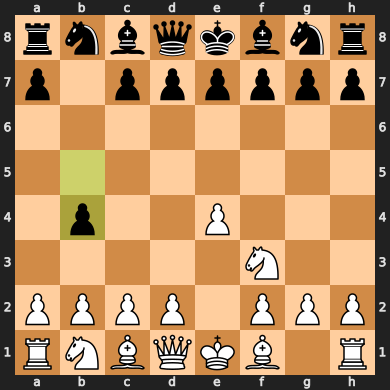

In [ ]:
if mode == 'play':
    if player_color == 'black':
        play_black()
    if player_color == 'white':
        play_white()